In [51]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import yfinance as yf
#import preprocessing 

In [52]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [53]:
# FOR REPRODUCIBILITY
np.random.seed(7)

tickerSymbol = 'AAPL'
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
dataset = tickerData.history(period='1d', start='2010-1-1', end='2020-1-25',)

dataset=dataset[["Open","High","Low","Close"]]
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = dataset.reindex(index = dataset.index[::-1])

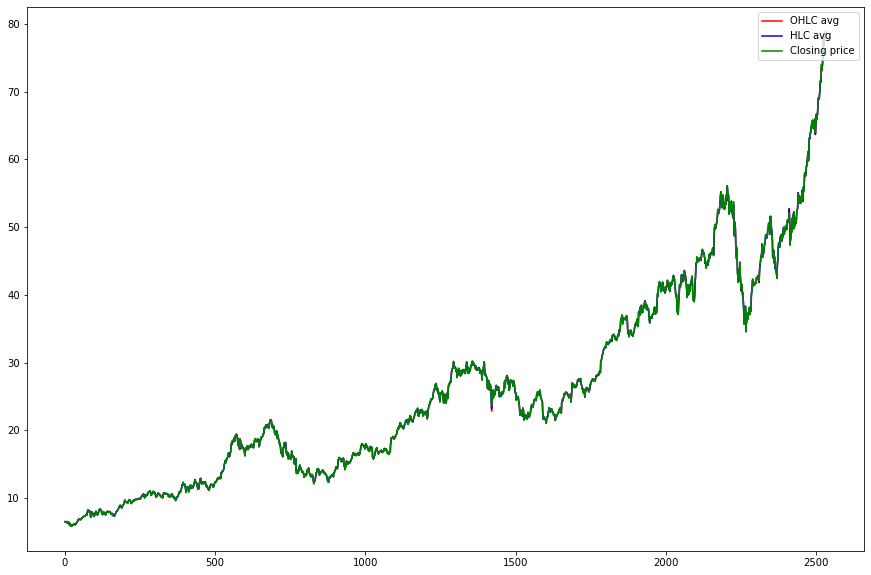

In [54]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.figure(figsize=(15, 10))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [55]:
# PREPARATION OF TIME SERIES DATASE
step_size = 1
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, step_size)
testX, testY = new_dataset(test_OHLC, step_size)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [56]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
#model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation("linear"))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='SGD') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1897/1897 - 8s - loss: 0.0113 - 8s/epoch - 4ms/step
Epoch 2/20
1897/1897 - 5s - loss: 0.0099 - 5s/epoch - 3ms/step
Epoch 3/20
1897/1897 - 5s - loss: 0.0090 - 5s/epoch - 3ms/step
Epoch 4/20
1897/1897 - 5s - loss: 0.0081 - 5s/epoch - 3ms/step
Epoch 5/20
1897/1897 - 6s - loss: 0.0071 - 6s/epoch - 3ms/step
Epoch 6/20
1897/1897 - 7s - loss: 0.0063 - 7s/epoch - 4ms/step
Epoch 7/20
1897/1897 - 6s - loss: 0.0054 - 6s/epoch - 3ms/step
Epoch 8/20
1897/1897 - 7s - loss: 0.0045 - 7s/epoch - 4ms/step
Epoch 9/20
1897/1897 - 7s - loss: 0.0037 - 7s/epoch - 3ms/step
Epoch 10/20
1897/1897 - 5s - loss: 0.0029 - 5s/epoch - 3ms/step
Epoch 11/20
1897/1897 - 7s - loss: 0.0023 - 7s/epoch - 3ms/step
Epoch 12/20
1897/1897 - 7s - loss: 0.0017 - 7s/epoch - 3ms/step
Epoch 13/20
1897/1897 - 8s - loss: 0.0013 - 8s/epoch - 4ms/step
Epoch 14/20
1897/1897 - 6s - loss: 9.2005e-04 - 6s/epoch - 3ms/step
Epoch 15/20
1897/1897 - 6s - loss: 6.4944e-04 - 6s/epoch - 3ms/step
Epoch 16/20
1897/1897 - 6s - loss: 4.4908

In [57]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict=trainPredict[:,:,0]
testPredict=testPredict[:,:,0]

# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Train RMSE: 0.64
Test RMSE: 3.05


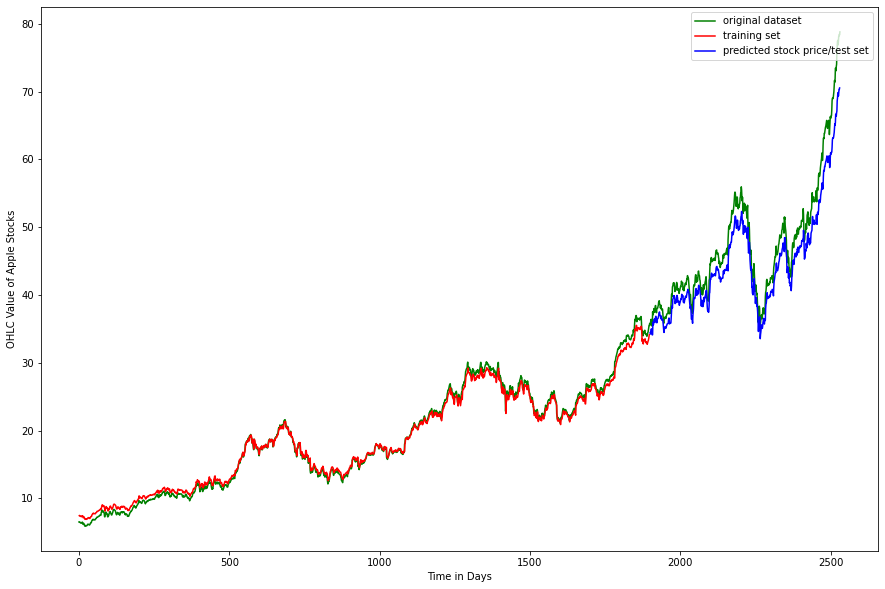

In [58]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(15, 10))
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.rcParams["figure.figsize"] = (2,20)
plt.show()

In [52]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))
#print (np.append(last_val, next_val))

Last Day Value: 136.19937133789062
Next Day Value: 107.83853912353516


C:\Users\oorsel2\AppData\Local\Temp/ipykernel_17304/2253948950.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Last Day Value:", np.asscalar(last_val))
C:\Users\oorsel2\AppData\Local\Temp/ipykernel_17304/2253948950.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(last_val*next_val))
